# RAG

### Retrieval Augmented Generation

La maggior parte dei dati esistenti è "privata" ma gli LLM sono trained con dati pubblici.
Dal momento che la context window degli LLM sta diventando sempre pià ampia, è possibile passare agli LLM (già trained su public data) i dati "private" (mai visti) sulla base dei quali creare la risposta.

Si compone di 3 step :
- INDEXING (dei dati esterni su un database che può essere relazionale, vectorstore, graph..)
- RETRIEVAL (estrazione dei dati sulla base di una richiesta)
- GENERATION (creazione di una risposta sulla base di quanto estratto nella fase precedente)

### INDEXING

Consiste nel caricare documenti "esterni" all'interno di un retriever (il cui compito è quello di estrarre successivamente i documenti sulla base di una input question).

Per consentire ciò è necessario convertire il testo in una numerical rappresentation in modo da consentire un più facile confronto.
Come rappresentazione numerica si possono utilizzare modelli :
- statistici : come Bag Of Word (sparse vector)
- basati su machine learning : embedding (dense vector)

Per consentire di fare embedding è necessario effettuare uno split dei documenti in input a causa dei limiti di context window dei modelli che effettuano embedding.
A seguito di embedding ogni documento è compresso in un vector che cattura il significato semantico del documento stesso.
Anche la domanda viene sottoposta allo stesso processo di embedding in modo da consentire il confronto numerico dei rispettivi vettori al fine di individuare i documenti maggiormente rilevanti per la domanda in oggetto

Come dimostrazione iniziale parto da un documento e una domanda

In [1]:
# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

question = "Qual'è il miglior linguaggio di programmazione per scrivere siti web?"
#document = "java è un linguaggio di programmazione ad oggetti"
document = "oggi il tempo è molto piovoso"

Solo a scopo dimostrativo, calcolo in numero di tokens partendo da un testo utilizzando la libreria tiktoken

In [2]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(question, "cl100k_base")

17

Utilizzo un embedding model di HuggingFace ottenere la rappresentazione numerica (embedding) della domanda e del documento.
Il nostro embedding model crea un vector di 768 che contiene il significato semantico del testo inziale.
Se avessimo usato OpenAIEmbeddings, il vettore sarebbe stato di 1536
--- sostituito il modello con un altro sulla base di
https://www.sbert.net/docs/pretrained_models.html. In questo caso il vector è 384

In [3]:
from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
#model_name = "nreimers/MiniLM-L6-H384-uncased"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf_Embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

#embd = OpenAIEmbeddings()

query_result = hf_Embeddings.embed_query(question)
document_result = hf_Embeddings.embed_query(document)
len(query_result)

/home/michele/anaconda3/envs/langchain_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


768

Un possibile modo per confrontare 2 embedding vectors è utilizzare <b>Cosine Similarity<b>

In [4]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.4382078723118073


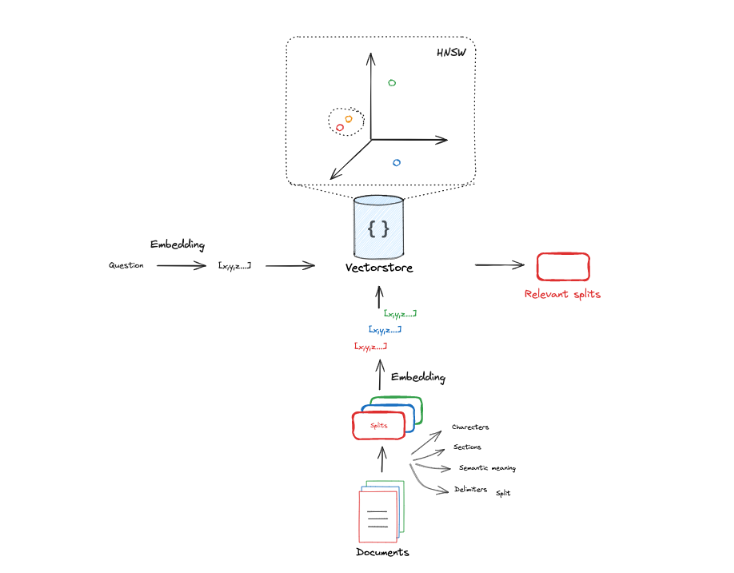

Vediamo ora un esempio completo di tutte le fasi che compongono il processo "base" di RAG.

Iniziamo dalla fase di indexing di un documento di testo scaricato dal web ed elaborato con BeautyfullSoup.

In [5]:
#### INDEXING ####

# Load blog
#
import bs4
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()
print(blog_docs)

[Document(page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final re

Dopo aver scaricato il documento è possibile procedere con lo split del documento in chunks di dimensioni tali da rendere possibile l'embedding

In [6]:
# Split
#
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
#
splits = text_splitter.split_documents(blog_docs)

Una volta ottenuti i chunks è possibile importarli sul vectorstore.

Per consentire tale importazione viene fatta preventivamente una conversione dei vari split nei relativi embedding (utilizzando l'embedding model definito prima) i quali vengono archiviati nel vectorstore con un puntamento ad documento (chunk) vero e proprio 

## Retrieval

Una volta che i documenti sono stati archiviati nel vectorestore è possibile procedere con l'estrazione dei documenti maggiormente rilevanti sulla base di:

- una domanda di input
- un criterio di similarity search

In questo modo vengono estratti i documenti che hanno un significato semanticamente simile alla domanda.


In [7]:
# Retrieval

from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=hf_Embeddings)


# setto il numero di documenti da estrarre
#
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [8]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")

/home/michele/anaconda3/envs/langchain_env/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [9]:
len(docs)

1

In [10]:
print(docs)

[Document(page_content='Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)\nThe system comprises of 4 stages:\n(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to guide LLM to do task parsing and planning.\nInstruction:', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'})]


### Generation

In questa fase vengono utilizzati i documenti estratti nella fase precedente e questi vengono inseriti nella context window del modello di LLM che dovrà produrre la risposta.

I documenti vengono inseriti all'interno del prompt insieme alla domanda.

Il prompt viene quindi passato all'LLM che produrrà la risposta alla domanda utilizzando il contenuto del documento

In [11]:
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'))])

In [12]:
from langchain_community.llms import CTransformers

llm = CTransformers(model='../llamacpp/models/mistral-7b-instruct-v0.1.Q4_K_M.gguf')

In [13]:
# Chain
chain = prompt | llm

In [14]:
# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"})

'\nAnswer: Task Decomposition refers to the process of breaking down a complex task into smaller, more manageable tasks in order to carry out each component of the larger task. This can involve identifying the necessary components, prioritizing their execution, and determining how they are best integrated within the system as a whole.'